In [ ]:
!pip install --quiet --upgrade --force-reinstall torch==1.9
!pip install --quiet --force-reinstall cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl
!pip install --quiet --upgrade transformers==4.10.3


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
torchvision 0.11.1+cu111 requires torch==1.10.0, but you have torch 1.9.0 which is incompatible.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.9.0 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.9.0 which is incompatible.
arviz 0.11.4 requires typing-extensions<4,>=3.7.4.3, but you have typing-extensions 4.1.1 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.9.0 whi

In [ ]:
!pip install wandb 
import wandb
wandb.login()

     |████████████████████████████████| 1.7 MB 5.4 MB/s 
     |████████████████████████████████| 180 kB 51.1 MB/s 
     |████████████████████████████████| 144 kB 47.8 MB/s 
     |████████████████████████████████| 63 kB 1.5 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=a088bef71cb628e4409d116e6e4f1497f989e5532a12f55b6a0babe61f9633d2
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
!pip install -U albumentations
!pip install datasets


In [ ]:
%env WANDB_PROJECT=Covid_Classification_FinalDataset 

env: WANDB_PROJECT=Covid_Classification_FinalDataset


In [ ]:
!pip install torchmetrics

In [ ]:
!pip uninstall opencv-python-headless==4.5.5.62

Found existing installation: opencv-python-headless 4.1.2.30
Uninstalling opencv-python-headless-4.1.2.30:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/cv2/*
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless-4.1.2.30.dist-info/*
  Would not remove (might be manually added):
    /usr/local/lib/python3.7/dist-packages/cv2/.libs/libQtCore-bbdab771.so.4.8.7
    /usr/local/lib/python3.7/dist-packages/cv2/.libs/libQtGui-903938cd.so.4.8.7
    /usr/local/lib/python3.7/dist-packages/cv2/.libs/libQtTest-1183da5d.so.4.8.7
Proceed (y/n)? y
  Successfully uninstalled opencv-python-headless-4.1.2.30


In [ ]:
!pip install opencv-python-headless==4.1.2.30

  Using cached opencv_python_headless-4.1.2.30-cp37-cp37m-manylinux1_x86_64.whl (21.8 MB)


In [ ]:
import cv2
import torchvision
import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import glob
import numpy as np
import random
import matplotlib.pyplot as plt
import math
from PIL import Image, UnidentifiedImageError
from pathlib import Path
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
#from torchmetrics import Accuracy
from torch.utils.data import Dataset
import copy
from transformers import ViTFeatureExtractor, ViTForImageClassification, Trainer, TrainingArguments
#from datasets import load_metric
#from sklearn.metrics import *

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

In [ ]:
train_transforms = A.Compose(
    [
        #A.SmallestMaxSize(max_size=350),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=180, p=0.5),
        #A.RandomCrop(height=224, width=224),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.MultiplicativeNoise(multiplier=[0.5,2], per_channel=True, p=0.2),
        #A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
        A.GaussNoise(var_limit=(10.0, 50.0), mean=0, per_channel=True, always_apply=False, p=0.5),
        A.GaussianBlur (blur_limit=(5, 9), sigma_limit=0, always_apply=False, p=0.5),
        ToTensorV2(),
    ]
)

test_transforms = A.Compose(
    [
        #A.SmallestMaxSize(max_size=350),
        #A.CenterCrop(height=224, width=224),
        #A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)



In [ ]:
def flatten_list(_2d_list):
    flat_list = []
    for element in _2d_list:
        if type(element) is list:
            for item in element:
                flat_list.append(item)
        else:
            flat_list.append(element)
    return flat_list

In [ ]:
train_data_path = '/content/drive/MyDrive/Datasets/Final Dataset/train' 
test_data_path = '/content/drive/MyDrive/Datasets/Final Dataset/test'
showcase_data_path = '/content/drive/MyDrive/Datasets/Final Dataset/test'

train_image_paths = [] #to store image paths in list
classes = [] #to store class values

for data_path in glob.glob(train_data_path + '/*'):
    classes.append(data_path.split('/')[-1]) 
    train_image_paths.append(glob.glob(data_path + '/*'))
    
train_image_paths = list(flatten_list(train_image_paths))
random.shuffle(train_image_paths)

print('train_image_path example: ', train_image_paths[0])
print('class example: ', classes)

#2.
# split train valid from train paths (80,20)
train_image_paths, valid_image_paths = train_image_paths[:int(0.75*len(train_image_paths))], train_image_paths[int(0.75*len(train_image_paths)):] 

#3.
# create the test_image_paths
test_image_paths = []
for data_path in glob.glob(test_data_path + '/*'):
    test_image_paths.append(glob.glob(data_path + '/*'))

test_image_paths = list(flatten_list(test_image_paths))

print("Train size: {}\nValid size: {}\nTest size: {}".format(len(train_image_paths), len(valid_image_paths), len(test_image_paths)))

NameError: ignored

In [ ]:
#      Create dictionary for class indexes

idx_to_class = {0: 'COVID' , 1: 'Normal', 2: 'Pneumonia'}
class_to_idx = {'COVID': 0, 'Normal': 1, 'Pneumonia': 2}

print(idx_to_class)
print(class_to_idx)

{0: 'COVID', 1: 'Normal', 2: 'Pneumonia'}
{'COVID': 0, 'Normal': 1, 'Pneumonia': 2}


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, image_paths, transform=False):
        self.image_paths = image_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        bgr = cv2.imread(image_filepath)

        #resize
        bgr = cv2.resize(bgr, (224, 224))

        #normalization
        norm = np.zeros((224,224))
        bgr = cv2.normalize(bgr,  norm, 0, 255, cv2.NORM_MINMAX)
        

        #clahe
        lab = cv2.cvtColor(bgr, cv2.COLOR_BGR2LAB)
        lab_planes = cv2.split(lab)
        lab_planes = list(lab_planes)
        clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(8,8))
        lab_planes[0] = clahe.apply(lab_planes[0])
        lab = cv2.merge(lab_planes)
        bgr = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

        image = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
        
        #zero center
        #image -= image.mean(axis=(-2,-1),keepdims=1)
        #mean = image.mean(axis=(0,1,2))
        #std = image.std(axis=(0,1,2))
        #image[..., 0] -= mean[0]
        #image[..., 1] -= mean[1]
        #image[..., 2] -= mean[2]

        label = image_filepath.split('/')[-2]
        label = class_to_idx[label]
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        return image, label
    

train_dataset = CustomDataset(train_image_paths,train_transforms)
valid_dataset = CustomDataset(valid_image_paths,test_transforms) 
test_dataset = CustomDataset(test_image_paths,test_transforms)

In [ ]:
print('The shape of tensor for 40th image in train dataset: ',train_dataset[39][0].shape)
print('The label for 40th image in train dataset: ',train_dataset[0][1])

The shape of tensor for 40th image in train dataset:  torch.Size([3, 224, 224])
The label for 40th image in train dataset:  0


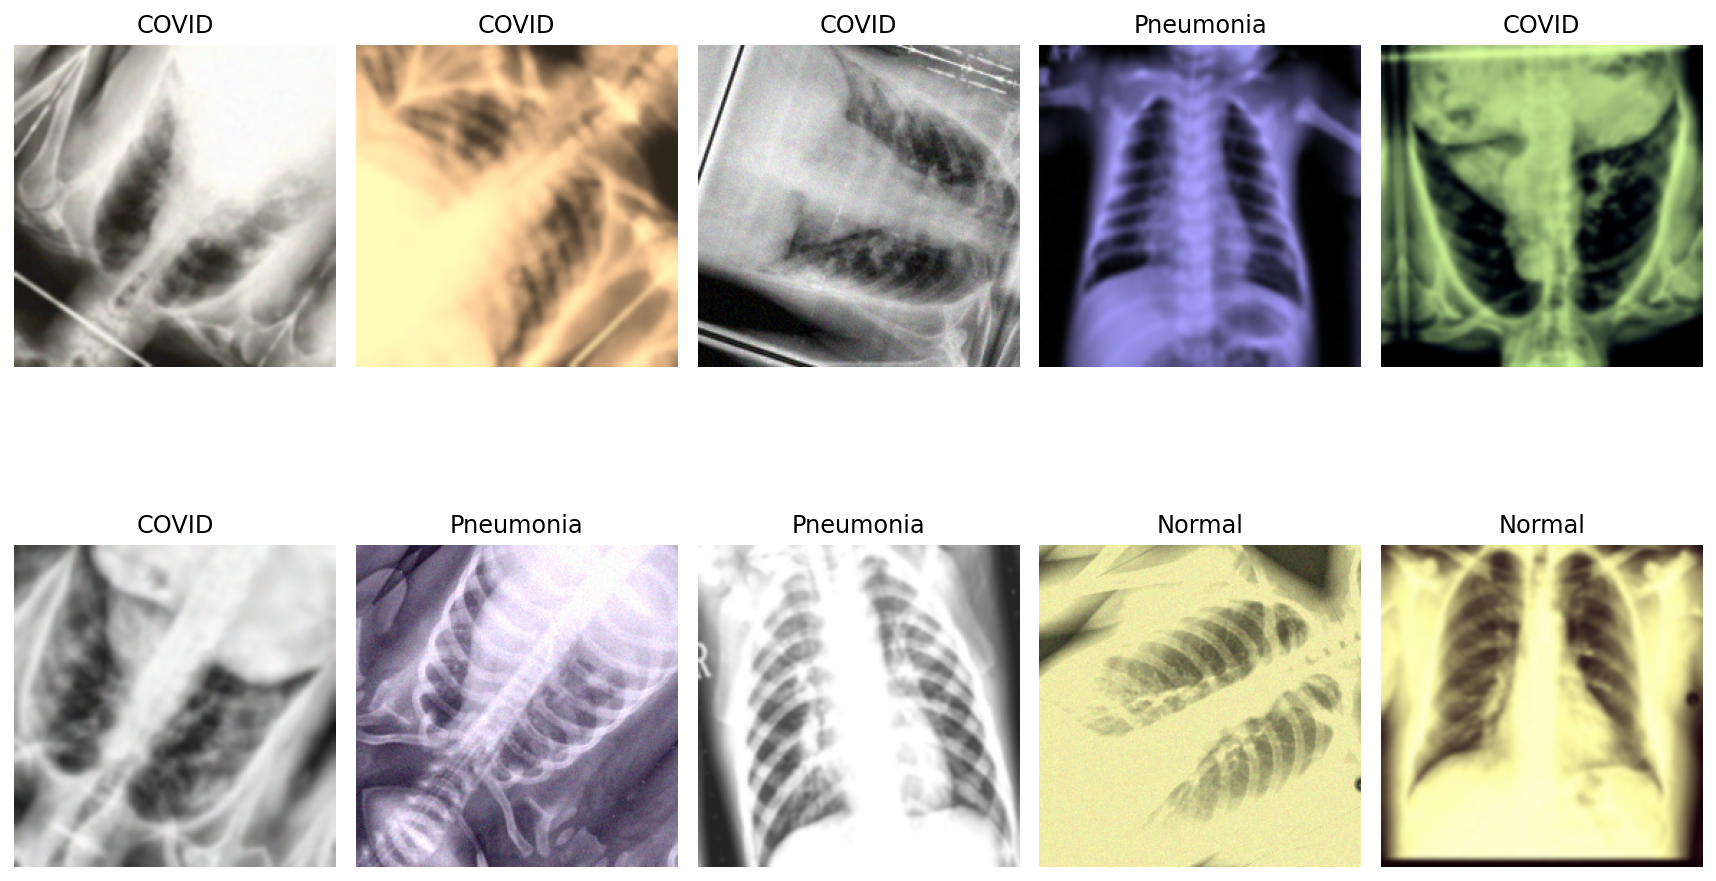

In [ ]:

def visualize_augmentations(dataset, idx=0, samples=10, cols=5, random_img = False):

    dataset = copy.deepcopy(dataset)

    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols


    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 8))
    for i in range(samples):
        if random_img:
            idx = np.random.randint(1,len(train_image_paths))
        image, lab = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
        ax.ravel()[i].set_title(idx_to_class[lab])
    plt.tight_layout(pad=1)
    plt.show()

visualize_augmentations(train_dataset,np.random.randint(1,len(train_image_paths)), random_img = True)


In [ ]:
from torch.utils.data import DataLoader
trainloader = DataLoader(
    train_dataset, batch_size=8, shuffle=True
)

valloader = DataLoader(
    valid_dataset, batch_size=8, shuffle=True
)


testloader = DataLoader(
    test_dataset, batch_size=8, shuffle=False
)

In [ ]:
class ImageClassificationCollator:
   def __init__(self, feature_extractor): 
      self.feature_extractor = feature_extractor
   def __call__(self, batch):  
      encodings = self.feature_extractor([x[0] for x in batch],
      return_tensors='pt')   
      encodings['labels'] = torch.tensor([x[1] for x in batch],    
      dtype=torch.long)
      return encodings

In [ ]:
metric = load_metric("glue","mrpc", average="micro")
def compute_metrics(eval_preds):
  logits, labels = eval_preds
  predictions = np.argmax(logits, axis=1)
  accuracy = round(accuracy_score(labels, predictions),3)
  micro_f1 = round(f1_score(labels, predictions, average = "micro"),3)
  macro_f1 = round(f1_score(labels, predictions, average = "macro"),3)
  return {"Accuracy":accuracy, "Micro F1": micro_f1, "Macro F1": macro_f1}
  #return metric.compute(predictions=predictions, references=labels, micro_f1=micro_f1, macro_f1=macro_f1)
  #return metric.compute(predictions=predictions, references=labels)

In [ ]:
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
collator = ImageClassificationCollator(feature_extractor)
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

loading feature extractor configuration file https://huggingface.co/google/vit-base-patch16-224/resolve/main/preprocessor_config.json from cache at /root/.cache/huggingface/transformers/caa0e8430c8ba68a0586cef2a661b39ea04de291f092f7c4277fc2d97f10cdb9.c322cbf30b69973d5aae6c0866f5cba198b5fe51a2fe259d2a506827ec6274bc
Feature extractor ViTFeatureExtractor {
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "ViTFeatureExtractor",
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "size": 224
}

loading configuration file https://huggingface.co/google/vit-base-patch16-224/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/6b03b61d64598274e01717c40e8909f9e70531219a281e8163bd5b3af5c92d1a.c41e6c561c79e9b15e74a5cc284a31cba59cb1a9e209933c1a04a46ba2e20e44
Model config ViTConfig {
  "_name_or_path": "google/vit-base-patch16-224",
  "architectures": [
    "ViTForImageClassification"
  ],

In [ ]:
wandb.init(project="Covid_Classification_FinalDataset", entity="msa499")
wandb.config = {
  "learning_rate": 0.0001,
  "epochs": 30,
  "batch_size": 30
}

In [ ]:
training_args = TrainingArguments(output_dir='/content/drive/MyDrive/outputs', do_train=True, per_device_train_batch_size=30, per_device_eval_batch_size=30, 
                                  learning_rate=1e-4, weight_decay=0.01, max_steps= 6000, warmup_steps=300, 
                                  dataloader_num_workers=2, report_to="wandb", dataloader_drop_last=True,
                                  ignore_data_skip=True,
                                  seed=2, 
                                  tpu_num_cores=8,
                                  evaluation_strategy="epoch"
                                  
                                )
trainer = Trainer(model=model, args=training_args, data_collator=collator, train_dataset=train_dataset,eval_dataset=valid_dataset, compute_metrics=compute_metrics)

PyTorch: setting up devices
max_steps is given, it will override any value given in num_train_epochs


In [ ]:
trainer.train()

***** Running training *****
  Num examples = 9000
  Num Epochs = 20
  Instantaneous batch size per device = 30
  Total train batch size (w. parallel, distributed & accumulation) = 30
  Gradient Accumulation steps = 1
  Total optimization steps = 6000
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
/usr/local/lib/python3.7/dist-packages/transformers/modeling_utils.py:382: UserWarning: Could not estimate the number of tokens of the input, floating-point operations will not be computed
  "Could not estimate the number of tokens of the input, floating-point operations will not be computed"


Epoch,Training Loss,Validation Loss,Accuracy,Micro f1,Macro f1
1,No log,0.334869,0.875000,0.875000,0.872000
2,0.981200,0.184126,0.938000,0.938000,0.938000
3,0.981200,0.247826,0.917000,0.917000,0.917000
4,0.302800,0.150548,0.949000,0.949000,0.948000
5,0.234000,0.205103,0.925000,0.925000,0.925000
6,0.234000,0.156585,0.951000,0.951000,0.951000
7,0.194900,0.175651,0.947000,0.947000,0.947000
8,0.194900,0.162553,0.951000,0.951000,0.951000
9,0.163400,0.171646,0.950000,0.950000,0.950000
10,0.142600,0.165321,0.950000,0.950000,0.950000


***** Running Evaluation *****
  Num examples = 3000
  Batch size = 30
/usr/local/lib/python3.7/dist-packages/transformers/modeling_utils.py:382: UserWarning: Could not estimate the number of tokens of the input, floating-point operations will not be computed
  "Could not estimate the number of tokens of the input, floating-point operations will not be computed"
Saving model checkpoint to /content/drive/MyDrive/outputs/checkpoint-500
Configuration saved in /content/drive/MyDrive/outputs/checkpoint-500/config.json
Model weights saved in /content/drive/MyDrive/outputs/checkpoint-500/pytorch_model.bin
/usr/local/lib/python3.7/dist-packages/transformers/modeling_utils.py:382: UserWarning: Could not estimate the number of tokens of the input, floating-point operations will not be computed
  "Could not estimate the number of tokens of the input, floating-point operations will not be computed"
***** Running Evaluation *****
  Num examples = 3000
  Batch size = 30
/usr/local/lib/python3.7/dist

TrainOutput(global_step=6000, training_loss=0.21088401254018146, metrics={'train_runtime': 9714.594, 'train_samples_per_second': 18.529, 'train_steps_per_second': 0.618, 'total_flos': 0.0, 'train_loss': 0.21088401254018146, 'epoch': 20.0})

In [ ]:
prediction = trainer.predict(test_dataset)
print(prediction.metrics)

***** Running Prediction *****
  Num examples = 3000
  Batch size = 30


{'test_loss': 0.21353060007095337, 'test_Accuracy': 0.958, 'test_Micro F1': 0.958, 'test_Macro F1': 0.958, 'test_runtime': 827.4374, 'test_samples_per_second': 3.626, 'test_steps_per_second': 0.121}


In [ ]:
print(prediction.predictions)

[[ 1.4144415 14.270416   5.0776687 ... -5.4654527 -4.4856205 -4.037043 ]
 [ 0.570131  13.781867   3.986289  ... -4.515092  -4.2531037 -3.4760725]
 [ 3.8561902 14.354216   4.623126  ... -5.5919523 -4.5005226 -4.5244617]
 ...
 [14.878289   4.072171   4.1629148 ... -4.5119653 -3.6746268 -4.002998 ]
 [15.363199   3.222847   2.430049  ... -4.1412554 -2.5762246 -3.9048686]
 [15.556894   2.9827359  2.1837077 ... -3.6588879 -3.1348352 -3.7545762]]


In [ ]:
class_names = {0: 'COVID', 1: 'Normal', 2: 'Pneumonia'}
print(prediction.label_ids.shape)
preds = np.argmax(prediction.predictions, axis=1)
print(preds.shape)

(3000,)
(3000,)


In [ ]:
wandb.log({"conf_mat" : wandb.plot.confusion_matrix(probs=None,
                        y_true=prediction.label_ids, preds=preds,
                        class_names=class_names)})

test_table = wandb.Table(columns=["Test Accuracy", "Test Loss"], data=[[prediction.metrics['test_Accuracy'],prediction.metrics['test_loss'] ]])
wandb.log({"test": test_table})

In [ ]:
gt = []
i =0
for x in range(1000):
  gt.append(0)

for x in range(1000):
  gt.append(1)

for x in range(1000):
  gt.append(2)


gt

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [ ]:
pr = []

for x in range(889):
  pr.append(0)
for x in range(57):
  pr.append(1)
for x in range(54):
  pr.append(2)

for x in range(24):
  pr.append(0)
for x in range(936):
  pr.append(1)
for x in range(40):
  pr.append(2)

for x in range(22):
  pr.append(0)
for x in range(22):
  pr.append(1)
for x in range(956):
  pr.append(2)

In [ ]:
#gt=flatten_list(prediction.label_ids)
#pr=flatten_list(preds)

  
def precisionCovid():
  i=0
  precision = 0
  true_positive =903
  true_negative = 0
  false_positive = 63
  flase_negative = 97
  total =966     #true_positive+flase_positive
  for items in gt:
    if gt[i]== 1 and pr[i]==1:
      true_positive = true_positive + 1
    i = i+1
  return true_positive/total

def recallCovid():
  i=0
  recall = 0
  true_positive =903
  true_negative = 0
  false_positive = 63
  flase_negative = 97
  total = 1000    #true_positive+false_negative
  for items in gt:
    if gt[i]== 1 and pr[i]==1:
      true_positive = true_positive + 1
    i = i+1
  return true_positive/total


def precisionNormal():
  i=0
  precision = 0
  true_positive =939
  true_negative = 0
  false_positive = 78
  flase_negative = 59
  total =1017
  for items in gt:

    if gt[i]== 0 and pr[i]==0:
      true_positive = true_positive + 1
    i = i+1
  return true_positive/total

def recallNormal():
  i=0
  recall = 0
  true_positive =939
  true_negative = 0
  false_positive = 78
  flase_negative = 59
  total =998
  for items in gt:
    if gt[i]== 0 and pr[i]==0:
      true_positive = true_positive + 1
 
    i = i+1
  return true_positive/total

def precisionPneumonia():
  i=0
  precision = 0
  true_positive =955
  true_negative = 0
  false_positive = 62
  flase_negative = 47
  total =1017
  for items in gt:
    if gt[i]== 2 and pr[i]==2:
      true_positive = true_positive + 1
    i = i+1
  return true_positive/total

def recallPneumonia():
  i=0
  recall = 0
  true_positive =955
  true_negative = 0
  false_positive = 62
  flase_negative = 47
  total =1002
  for items in gt:
    if gt[i]== 2 and pr[i]==2:
      true_positive = true_positive + 1
    if pr[i]==2:
      total = total + 1
    i = i+1
  return true_positive/total

In [ ]:
precisionC= precisionCovid()
recallC= recallCovid()
precisionN= precisionNormal()
recallN= recallNormal()
precisionP= precisionPneumonia()
recallP= recallPneumonia()



In [ ]:
precisionC= precisionCovid()
recallC= recallCovid()
precisionN= precisionNormal()
recallN= recallNormal()
precisionP= precisionPneumonia()
recallP= recallPneumonia()
table = wandb.Table(columns=["Precicion(COVID)", "Recall(COVID)", "Precicion(Normal)", "Recall(Normal)","Precicion(Pneumonia)", "Recall(Pneumonia)"], data=[[precisionC,recallC,precisionN,recallN,precisionP,recallP]])
wandb.log({"table_key": table})

In [ ]:
wandb.finish()

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score


In [ ]:
ytrue = prediction.label_ids.tolist()
pred = prediction.predictions.tolist()

In [ ]:
prediction

PredictionOutput(predictions=array([[ 1.4144415, 14.270416 ,  5.0776687, ..., -5.4654527, -4.4856205,
        -4.037043 ],
       [ 0.570131 , 13.781867 ,  3.986289 , ..., -4.515092 , -4.2531037,
        -3.4760725],
       [ 3.8561902, 14.354216 ,  4.623126 , ..., -5.5919523, -4.5005226,
        -4.5244617],
       ...,
       [14.878289 ,  4.072171 ,  4.1629148, ..., -4.5119653, -3.6746268,
        -4.002998 ],
       [15.363199 ,  3.222847 ,  2.430049 , ..., -4.1412554, -2.5762246,
        -3.9048686],
       [15.556894 ,  2.9827359,  2.1837077, ..., -3.6588879, -3.1348352,
        -3.7545762]], dtype=float32), label_ids=array([1, 1, 1, ..., 0, 0, 0]), metrics={'test_loss': 0.21353060007095337, 'test_Accuracy': 0.958, 'test_Micro F1': 0.958, 'test_Macro F1': 0.958, 'test_runtime': 827.4374, 'test_samples_per_second': 3.626, 'test_steps_per_second': 0.121})